In [2]:
# !pip install rpy2
# !conda install -c conda-forge rpy2 -y

%load_ext rpy2.ipython

Error importing in API mode: ImportError('libopenblas.so.0: cannot open shared object file: No such file or directory')
Trying to import in ABI mode.


In [5]:
%%R

library(glmnet)
library(lme4)
library(dplyr)
library(ggplot2)
library(tidyr)

# Bootstrap 설정
B_selection <- 100
B_inference <- 100
threshold   <- 0.6

target_files <- list(
    "oxygen" = "106_oxygen.csv",
    "urea"   = "106_urea.csv",
    "crp"    = "106_crp.csv"
)

final_results <- list()

[1] "=========================================="
[1] "Starting Analysis for: oxygen"
[1] "Loading File: 106_oxygen.csv"
[1] ">> Running Stability Selection for oxygen ..."
[1] "Selected Stable Features: 7"
[1] "age"                 "bmi"                 "IL.6.pg.ml."        
[4] "ADAMTS13.pg.ml."     "IL.18.IL.1F4.pg.ml." "IGLJ2"              
[7] "IGLV8.61"           
[1] ">> Running Bootstrap LMM for oxygen ..."
[1] "Saved Bootstrap Result: Bootstrap_LMM_Result_oxygen.csv"
                               Variable     Mean_Beta      Lower_CI
(Intercept)                 (Intercept)  9.940703e+01  9.554690e+01
age                                 age -1.043134e-02 -4.468658e-02
bmi                                 bmi -1.076412e-01 -2.458739e-01
IL.6.pg.ml.                 IL.6.pg.ml. -6.313593e-02 -1.760338e-01
ADAMTS13.pg.ml.         ADAMTS13.pg.ml.  1.042206e-06 -2.633275e-07
IL.18.IL.1F4.pg.ml. IL.18.IL.1F4.pg.ml. -2.054150e-03 -5.459254e-03
IGLJ2                             IGLJ2 -7.9

fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
In addition: There were 50 or more warnings (use warnings() to see the first 50)


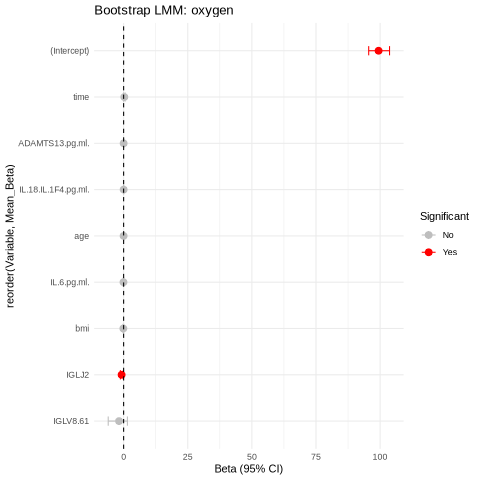

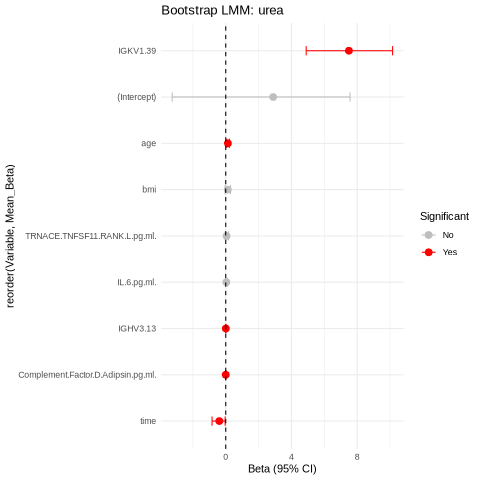

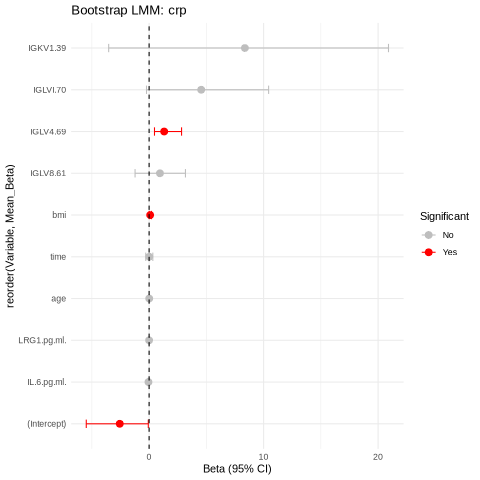

In [7]:
%%R
# -------------------------------------------------------------
# Main
# -------------------------------------------------------------
for (target_var in names(target_files)) {
    
    csv_file <- target_files[[target_var]]
    print(paste("=========================================="))
    print(paste("Starting Analysis for:", target_var))
    print(paste("Loading File:", csv_file))
    
    if (!file.exists(csv_file)) {
        print(paste("Error: File not found -", csv_file))
        next
    }
    ddd <- read.csv(csv_file)
    
    if ("days_y" %in% names(ddd)) ddd <- ddd[, !names(ddd) %in% "days_y"]
    if("age" %in% names(ddd)) ddd$age <- as.numeric(ddd$age)
    if("sex" %in% names(ddd)) ddd$sex <- as.factor(ddd$sex)
    if("bmi" %in% names(ddd)) ddd$bmi <- as.numeric(ddd$bmi)
    if("days" %in% names(ddd)) ddd$days <- as.numeric(ddd$days)
    if("ID" %in% names(ddd)) ddd$ID <- as.factor(ddd$ID)
    if(target_var %in% names(ddd)) {
        ddd[[target_var]] <- as.numeric(ddd[[target_var]])
    } else {
        print(paste("Error: Target variable", target_var, "not in dataset."))
        next
    }
    
    set.seed(42)
    unique_ids <- unique(ddd$ID)
    train_ids <- sample(unique_ids, size = floor(0.7 * length(unique_ids)))
    train_full <- ddd %>% filter(ID %in% train_ids)
    train_sub <- train_full[!is.na(train_full[[target_var]]), ]
    
    # -------------------------------------------------------------
    # Step 1: Stability Selection
    # -------------------------------------------------------------
    print(paste(">> Running Stability Selection for", target_var, "..."))
    exclude_vars <- c("ID", "time", "severity", "oxygen", "urea", "crp", "days")
    predictors <- setdiff(names(train_sub), exclude_vars)

    form_str <- paste(target_var, "~", paste(predictors, collapse = " + "))

    tryCatch({
        X_full <- model.matrix(as.formula(form_str), data = train_sub)[, -1]
        y_full <- train_sub[[target_var]]
        
        p_fac <- rep(1, ncol(X_full))
        curr_vars <- colnames(X_full)
        selection_counts <- rep(0, ncol(X_full))
        names(selection_counts) <- curr_vars
        
        for (b in 1:B_selection) {
            sub_ids <- sample(unique(train_sub$ID), size = floor(0.5 * length(unique(train_sub$ID))), replace = FALSE)
            sub_idx <- which(train_sub$ID %in% sub_ids)
            
            X_sub <- X_full[sub_idx, ]
            y_sub <- y_full[sub_idx]
            
            fit <- glmnet(X_sub, y_sub, alpha = 0.5, family = "gaussian", penalty.factor = p_fac)
            lambda_idx <- round(length(fit$lambda) / 2)
            coef_b <- coef(fit, s = fit$lambda[lambda_idx])
            
            sel_vars <- rownames(coef_b)[coef_b[,1] != 0]
            sel_vars <- setdiff(sel_vars, "(Intercept)")
            selection_counts[sel_vars] <- selection_counts[sel_vars] + 1
        }
        
        probs <- selection_counts / B_selection
        stable_features <- names(probs)[probs >= threshold]
        print(paste("Selected Stable Features:", length(stable_features)))
        print(stable_features)
        
        # -------------------------------------------------------------
        # Step 2: Bootstrap LMM Inference
        # -------------------------------------------------------------
        if(length(stable_features) > 0) {
            print(paste(">> Running Bootstrap LMM for", target_var, "..."))
        
            lmm_vars <- stable_features
            if(!"time" %in% lmm_vars & "time" %in% names(train_sub)) lmm_vars <- c(lmm_vars, "time")
            fixed_part <- paste(stable_features, collapse = " + ")
            if(!"time" %in% stable_features) fixed_part <- paste(fixed_part, "+ time")
            lmm_form <- as.formula(paste(target_var, "~", fixed_part, "+ (1 | ID)"))
            boot_coefs <- NULL
            
            for (b in 1:B_inference) {
                boot_ids <- sample(unique(train_sub$ID), length(unique(train_sub$ID)), replace = TRUE)
                boot_data_list <- lapply(boot_ids, function(id) train_sub[train_sub$ID == id, ])
                boot_data <- do.call(rbind, boot_data_list)
                
                try({
                    fit_lmm <- lmer(lmm_form, data = boot_data, control = lmerControl(optimizer = "bobyqa"))
                    betas <- fixef(fit_lmm)
                    
                    if(is.null(boot_coefs)) {
                        boot_coefs <- matrix(NA, nrow = B_inference, ncol = length(betas))
                        colnames(boot_coefs) <- names(betas)
                    }
                    boot_coefs[b, ] <- betas
                }, silent=TRUE)
            }
            
            if(!is.null(boot_coefs)) {
                boot_coefs <- na.omit(boot_coefs)
                res_df <- data.frame(
                    Variable = colnames(boot_coefs),
                    Mean_Beta = colMeans(boot_coefs),
                    Lower_CI = apply(boot_coefs, 2, quantile, probs = 0.025),
                    Upper_CI = apply(boot_coefs, 2, quantile, probs = 0.975)
                )
                res_df$Significant <- ifelse(res_df$Lower_CI > 0 | res_df$Upper_CI < 0, "Yes", "No")

                out_name <- paste0("Bootstrap_LMM_Result_", target_var, ".csv")
                write.csv(res_df, out_name, row.names = FALSE)
                print(paste("Saved Bootstrap Result:", out_name))
                print(res_df)
                
                p <- ggplot(res_df, aes(x = reorder(Variable, Mean_Beta), y = Mean_Beta, color = Significant)) +
                      geom_point(size = 3) +
                      geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI), width = 0.2) +
                      geom_hline(yintercept = 0, linetype = "dashed") +
                      coord_flip() +
                      scale_color_manual(values = c("Yes" = "red", "No" = "gray")) +
                      labs(title = paste("Bootstrap LMM:", target_var), y = "Beta (95% CI)") +
                      theme_minimal()
                print(p)
            }
        } else {
            print("No stable features selected. Skipping LMM.")
        }
        
    }, error = function(e) {
        print(paste("Error in processing", target_var, ":", e$message))
    })
    
    print("------------------------------------------")
}

### Python version

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
import os
import warnings

warnings.filterwarnings('ignore')

In [2]:
def run_stability_with_error_control(data, target, exclude_vars, B=100, base_threshold=0.6, max_vars=20):

    df_sub = data.dropna(subset=[target]).copy()
    current_cols = df_sub.columns.tolist()
    predictors = [c for c in current_cols if c not in exclude_vars and c != target]
    
    if not predictors:
        return None, [], {}
    
    X = df_sub[predictors]
    y = df_sub[target]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=predictors)
    
    unique_ids = df_sub['ID'].unique()
    n_subs = int(len(unique_ids) * 0.5) 
    
    selection_counts = pd.Series(0, index=predictors)
    total_selected_sum = 0
    
    print(f">> Running Stability Selection for {target} ({B} iter)...")
    
    for i in range(B):
        sampled_ids = np.random.choice(unique_ids, size=n_subs, replace=False)
        mask = df_sub['ID'].isin(sampled_ids)
        model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=i)
        model.fit(X_scaled[mask], y[mask])
        coef_series = pd.Series(model.coef_, index=predictors)
        selected = coef_series[coef_series != 0].index
        
        selection_counts[selected] += 1
        total_selected_sum += len(selected)
        
    probs = selection_counts / B
    current_threshold = base_threshold
    stable_vars = probs[probs >= current_threshold].index.tolist()
    
    if len(stable_vars) > max_vars:
        sorted_probs = probs[stable_vars].sort_values(ascending=False)
        new_threshold = sorted_probs.iloc[max_vars - 1]
        
        if new_threshold > current_threshold:
            print(f"!! Too many vars ({len(stable_vars)}). Increasing threshold: {current_threshold} -> {new_threshold:.2f}")
            current_threshold = new_threshold
            stable_vars = probs[probs >= current_threshold].index.tolist()
            
    # --- Meinshausen's Error Bound (PFER) ---
    # Formula: E[V] <= q^2 / ((2*pi - 1) * P)
    q = total_selected_sum / B if 'total_selected_sum' in locals() else total_selected_sum / B
    P = len(predictors)
    denominator = (2 * current_threshold - 1) * P
    PFER = (q**2) / denominator if denominator > 0 else np.inf
    error_stats = {
        'P (Total Vars)': P,
        'q (Avg Selected)': q,
        'Final Threshold': current_threshold,
        'PFER (Upper Bound)': PFER
    }
    
    final_vars = list(set(stable_vars))
    return probs, final_vars, error_stats


def run_bootstrap_lmm_with_pvals(data, target, selected_vars, group_col='ID', B=100):

    df_model = data.dropna(subset=[target]).copy()
    unique_ids = df_model[group_col].unique()
    fixed_effects = list(selected_vars)
    if 'time' not in fixed_effects and 'time' in df_model.columns:
        fixed_effects.append('time')
        
    formula = f"{target} ~ {' + '.join(fixed_effects)}"
    
    results_list = []
    success_count = 0
    
    print(f">> Bootstrap LMM for {target} ({B} iter)...")
    
    for i in tqdm(range(B)):
        try:
            # 1) Cluster Bootstrap
            resampled_ids = np.random.choice(unique_ids, size=len(unique_ids), replace=True)
            
            boot_data_list = []
            for new_idx, orig_id in enumerate(resampled_ids):
                subset = df_model[df_model[group_col] == orig_id].copy()
                subset[group_col] = f"{orig_id}_{new_idx}"
                boot_data_list.append(subset)
            boot_data = pd.concat(boot_data_list)
            
            # 2) LMM
            model = smf.mixedlm(formula, boot_data, groups=boot_data[group_col])
            fit = model.fit(maxiter=100, reml=False)
            
            if fit.converged:
                for var in fixed_effects:
                    if var == 'Intercept': continue
                    params = fit.params.filter(like=var)
                    pvals = fit.pvalues.filter(like=var)
                    
                    if len(params) > 0:
                        results_list.append({
                            'Iteration': i,
                            'Variable': var, 
                            'Beta': params.values[0],
                            'P_Value': pvals.values[0]
                        })
                success_count += 1
                
        except Exception:
            continue
            
    if success_count == 0:
        return None
        
    return pd.DataFrame(results_list)

print("Analysis functions defined.")

Analysis functions defined.


In [38]:
target_files = {
    "oxygen": "106_oxygen.csv",
    "urea":   "106_urea.csv",
    "crp":    "106_crp.csv"
}

global_exclude = ['ID', 'time', 'days', 'severity', 'oxygen', 'urea', 'crp']
selection_results = {}
processed_dfs = {}

for target, filename in target_files.items():
    print(f"\n{'='*40}")
    print(f"Phase 1: Selection for [{target}]")
    print(f"{'='*40}")
    
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        continue
        
    df = pd.read_csv(filename)
    
    if 'days_y' in df.columns: df = df.drop(columns=['days_y'])
    if 'ID' in df.columns: df['ID'] = df['ID'].astype(str)
    if 'sex' in df.columns: df['sex'] = df['sex'].astype('category')

    current_exclude = [v for v in global_exclude if v in df.columns]

    probs, stable_vars, stats = run_stability_with_error_control(
        df, target, current_exclude, 
        B=1000,
        base_threshold=0.6, 
        max_vars=80
    )
    
    selection_results[target] = {
        'probs': probs,
        'vars': stable_vars,
        'stats': stats
    }
    processed_dfs[target] = df
    
    print(f"\n[Meinshausen Bound Result]")
    print(f"- Final Threshold: {stats['Final Threshold']:.2f}")
    print(f"- Expected False Positives (PFER): <= {stats['PFER (Upper Bound)']:.4f}")
    print(f"- Selected Vars ({len(stable_vars)}): {stable_vars}")


Phase 1: Selection for [oxygen]
>> Running Stability Selection for oxygen (1000 iter)...

[Meinshausen Bound Result]
- Final Threshold: 0.60
- Expected False Positives (PFER): <= 152.6915
- Selected Vars (38): ['TRBV8-2', 'MMP.13.pg.ml.', 'BAFF.BLyS.TNFSF13B.pg.ml.', 'IGLV8-61', 'CCL22.MDC.pg.ml.', 'IGKV4-1', 'IGLV3-25', 'Angiopoietin.1.pg.ml.', 'IGLJ2', 'IGLV4-60', 'CCL18.PARC.pg.ml.', 'IGLV2-11', 'PD.L1.B7.H1.pg.ml.', 'IGLV1-40', 'alpha.2.Macroglobulin.pg.ml.', 'IGLV6-57', 'sex', 'ADAMTS13.pg.ml.', 'CCL2.JE.MCP.1.pg.ml.', 'TRAV8-7', 'age', 'IGLV1-51', 'IGKV2-30', 'Growth.Hormone.pg.ml.', 'IL.6.pg.ml.', 'CD117.c.kit.pg.ml.', 'IGLVI-70', 'MMP.3.pg.ml.', 'IL.18.IL.1F4.pg.ml.', 'CCL19.MIP.3.beta.pg.ml.', 'IGHV4-4', 'Syndecan.1.CD138.pg.ml.', 'IGLV3-9', 'Neuregulin.1.beta.NRG1.beta.1.pg.ml.', 'NT.4.pg.ml.', 'bmi', 'BDNF.pg.ml.', 'IL.10.pg.ml.']

Phase 1: Selection for [urea]
>> Running Stability Selection for urea (1000 iter)...

[Meinshausen Bound Result]
- Final Threshold: 0.60
- Expec

In [ ]:
# bootstrap_results = {}

# print(f"\n{'='*40}")
# print(f"Phase 2: Bootstrap Inference")
# print(f"{'='*40}")

# for target, info in selection_results.items():
#     stable_vars = info['vars']
#     probs = info['probs']
#     df = processed_dfs.get(target)
    
#     if df is None or len(stable_vars) == 0:
#         print(f"Skipping {target} (No data or no variables selected)")
#         continue
        
#     res_df = run_bootstrap_lmm_with_pvals(
#         df, target, stable_vars, group_col='ID', 
#         B=2000
#     )
    
#     if res_df is not None:
#         res_df['Selection_Prob'] = res_df['Variable'].map(probs)
#         bootstrap_results[target] = res_df
#         print(f"-> Completed Inference for {target}")
#     else:
#         print(f"-> Failed Inference for {target} (All iterations failed)")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import functools

warnings.filterwarnings('ignore')

from model import ManualJointModel, ManualLinearMixedModel

print("Loaded ManualJointModel & ManualLinearMixedModel from model.py")

Loaded ManualJointModel & ManualLinearMixedModel from model.py


In [4]:
def run_bootstrap_joint_model(data, formulas_dict, group_col='ID', B=100):
    unique_ids = data[group_col].unique()
    boot_results = []
    success_count = 0
    print(f">> Running Joint Bootstrap ({B} iterations)...")
    
    for i in tqdm(range(B)):
        try:
            resampled_ids = np.random.choice(unique_ids, size=len(unique_ids), replace=True)
            boot_data_list = []
            for new_idx, orig_id in enumerate(resampled_ids):
                subset = data[data[group_col] == orig_id].copy()
                subset[group_col] = f"{orig_id}_{new_idx}"
                boot_data_list.append(subset)
            
            boot_data = pd.concat(boot_data_list)
            
            # Joint Model 
            joint_model = ManualJointModel(formulas_dict, boot_data, group_col=group_col)
            joint_model.fit()
            for target_name, lmm_model in joint_model.fitted_models.items():
                betas = lmm_model.beta_hat
                if hasattr(lmm_model, 'X_df'):
                    feature_names = lmm_model.X_df.columns.tolist()
                else:
                    feature_names = [f"Beta_{k}" for k in range(len(betas))]

                for fname, val in zip(feature_names, betas):
                    if fname == 'Intercept': continue 
                    
                    boot_results.append({
                        'Iteration': i,
                        'Target': target_name,
                        'Variable': fname,
                        'Beta': val
                    })
            
            success_count += 1
            
        except Exception as e:
            continue
            
    if success_count == 0:
        print("All Joint Model iterations failed.")
        return None
        
    return pd.DataFrame(boot_results)

print("Joint Bootstrap function defined.")

Joint Bootstrap function defined.


In [51]:
# -----------------------------------------------------------
# Joint Bootstrap
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
target_files = {
    "oxygen": "106_oxygen.csv",
    "urea":   "106_urea.csv",
    "crp":    "106_crp.csv"
}
merged_df = None
print("Merging datasets and cleaning variable names...")

def clean_var_name(name):
    return name.replace('.', '_').replace('-', '_')

var_name_map = {}

for target, fname in target_files.items():
    if not os.path.exists(fname): continue
    
    df_part = pd.read_csv(fname)

    if 'days_y' in df_part.columns: df_part = df_part.drop(columns=['days_y'])
    if 'ID' in df_part.columns: df_part['ID'] = df_part['ID'].astype(str)
    
    new_cols = [clean_var_name(c) for c in df_part.columns]
    for old, new in zip(df_part.columns, new_cols):
        var_name_map[old] = new
    df_part.columns = new_cols
    
    for col in ['age', 'bmi', 'days']:
        if col in df_part.columns: df_part[col] = pd.to_numeric(df_part[col], errors='coerce')
    if 'sex' in df_part.columns: df_part['sex'] = df_part['sex'].astype('category')

    if merged_df is None:
        merged_df = df_part
    else:
        join_keys = ['ID']
        if 'time' in df_part.columns and 'time' in merged_df.columns:
            join_keys.append('time')
            
        merged_df = pd.merge(merged_df, df_part, on=join_keys, how='outer', suffixes=('', '_new'))
        for col in merged_df.columns:
            if col.endswith('_new'):
                original_col = col.replace('_new', '')
                if original_col in merged_df.columns:
                    merged_df[original_col] = merged_df[original_col].fillna(merged_df[col])
        merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_new')]

# print(f"Merged & Cleaned Data Shape: {merged_df.shape}")

formulas_dict = {}

for target in target_files.keys():
    if target in selection_results:
        stable_vars_old = selection_results[target]['vars']
        stable_vars_clean = [clean_var_name(v) for v in stable_vars_old]
        stable_vars_clean = [v for v in stable_vars_clean if v in merged_df.columns]

        if len(stable_vars_clean) > 20:
             probs = selection_results[target]['probs']
             probs.index = [clean_var_name(i) for i in probs.index]
             valid_probs = probs[probs.index.isin(stable_vars_clean)]
             stable_vars_clean = valid_probs.sort_values(ascending=False).head(20).index.tolist()
             print(f"-> Reduced {target} vars to top 20.")

        if not stable_vars_clean:
            stable_vars_clean = ['age', 'sex', 'bmi']
            
        fixed_effects = list(stable_vars_clean)
        if 'time' not in fixed_effects and 'time' in merged_df.columns:
            fixed_effects.append('time')
        rhs = " + ".join(fixed_effects)
        formulas_dict[target] = f"{target} ~ {rhs}"
        print(f"Formula [{target}]: {formulas_dict[target][:80]} ...")

# Joint Bootstrap
def run_bootstrap_joint_model_clean(data, formulas_dict, group_col='ID', B=100):
    unique_ids = data[group_col].unique()
    boot_results = []
    success_count = 0
    
    # print(f"\n>> Running Joint Bootstrap ({B} iterations)...")

    for i in tqdm(range(B), mininterval=0.5):
        try:
            # Cluster Resampling
            resampled_ids = np.random.choice(unique_ids, size=len(unique_ids), replace=True)
            
            boot_data_list = []
            for new_idx, orig_id in enumerate(resampled_ids):
                subset = data[data[group_col] == orig_id].copy()
                subset[group_col] = f"{orig_id}_{new_idx}"
                boot_data_list.append(subset)
            
            boot_data = pd.concat(boot_data_list)
        
            joint_model = ManualJointModel(formulas_dict, boot_data, group_col=group_col)
            joint_model.fit()
            
            for target_name, lmm_model in joint_model.fitted_models.items():
                if lmm_model.beta_hat is None: continue

                betas = lmm_model.beta_hat
                
                if hasattr(lmm_model, 'X_df'):
                    feature_names = lmm_model.X_df.columns.tolist()
                else:
                    feature_names = [f"Beta_{k}" for k in range(len(betas))]

                for fname, val in zip(feature_names, betas):
                    if fname == 'Intercept': continue
                    
                    boot_results.append({
                        'Iteration': i,
                        'Target': target_name,
                        'Variable': fname,
                        'Beta': val
                    })
            
            success_count += 1
            
        except Exception as e:
            if i == 0: 
                print(f"\n[Error at iter 0]: {str(e)}")
            continue
            
    if success_count == 0:
        print("All Joint Model iterations failed.")
        return None
        
    return pd.DataFrame(boot_results)

if 'ManualJointModel' in locals():
    joint_res_df = run_bootstrap_joint_model_clean(
        merged_df, 
        formulas_dict, 
        group_col='ID', 
        B=100
    )
    print("\n>>> Joint Bootstrap Completed.")
else:
    print("Error: ManualJointModel not loaded.")

Merging datasets and cleaning variable names...
-> Reduced oxygen vars to top 20.
Formula [oxygen]: oxygen ~ IGLV8_61 + Angiopoietin_1_pg_ml_ + IGLV1_40 + IL_18_IL_1F4_pg_ml_ + ADA ...
-> Reduced urea vars to top 20.
Formula [urea]: urea ~ Contactin_1_pg_ml_ + Thrombomodulin_BDCA_3_pg_ml_ + sex + age + IGLV9_49  ...
-> Reduced crp vars to top 20.
Formula [crp]: crp ~ LRG1_pg_ml_ + CD23_Fc_epsilon_RII_pg_ml_ + BAFF_BLyS_TNFSF13B_pg_ml_ + IGL ...


100%|██████████| 100/100 [24:10<00:00, 14.50s/it]


>>> Joint Bootstrap Completed.


In [5]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

target_files = {
    "oxygen": "106_oxygen.csv",
    "urea":   "106_urea.csv",
    "crp":    "106_crp.csv"
}

target_specific_vars = {
    "oxygen": ["age", "sex", "BAFF.BLyS.TNFSF13B.pg.ml.", "BDNF.pg.ml.", "CCL19.MIP.3.beta.pg.ml."],
    "urea": ["age", "sex", "BAFF.BLyS.TNFSF13B.pg.ml.", "CCL19.MIP.3.beta.pg.ml."],
    "crp": ["age", "sex", "CCL2.JE.MCP.1.pg.ml.", "CCL23.MPIF.1.pg.ml."]
}

def clean_var_name(name):
    return name.replace('.', '_').replace('-', '_')

# -----------------------------------------------------------
# Targetted result
# -----------------------------------------------------------
target_datasets = {}
formulas_dict = {}

for target, fname in target_files.items():
    if not os.path.exists(fname): 
        print(f"Warning: {fname} not found.")
        continue
    
    df = pd.read_csv(fname)
    if 'ID' in df.columns: df['ID'] = df['ID'].astype(str)
    original_cols = df.columns.tolist()
    df.columns = [clean_var_name(c) for c in original_cols]
    selected_vars = [clean_var_name(v) for v in target_specific_vars[target]]
    valid_vars = [v for v in selected_vars if v in df.columns]
    
    if 'time' in df.columns and 'time' not in valid_vars:
        valid_vars.append('time')
        
    rhs = " + ".join(valid_vars)
    formulas_dict[target] = f"{target} ~ {rhs}"

    target_datasets[target] = df
    print(f"Loaded {target}: {df.shape}, Formula: {formulas_dict[target][:50]}...")

# -----------------------------------------------------------
# Joint Bootstrap
# -----------------------------------------------------------
def run_bootstrap_joint_model_independent(datasets_dict, formulas_dict, group_col='ID', B=100):
    all_ids = set()
    for df in datasets_dict.values():
        all_ids.update(df[group_col].unique())
    unique_ids = list(all_ids)
    
    boot_results = []
    
    for i in tqdm(range(B)):
        try:
            resampled_ids = np.random.choice(unique_ids, size=len(unique_ids), replace=True)
        
            boot_data_map = {}
            for target, df in datasets_dict.items():
                boot_list = []
                for new_idx, orig_id in enumerate(resampled_ids):
                    subset = df[df[group_col] == orig_id].copy()
                    if not subset.empty:
                        subset[group_col] = f"{orig_id}_{new_idx}"
                        boot_list.append(subset)
                boot_data_map[target] = pd.concat(boot_list)

            joint_model = ManualJointModel(formulas_dict, boot_data_map, group_col=group_col)
            joint_model.fit()
            
            for target_name, lmm_model in joint_model.fitted_models.items():
                if lmm_model.beta_hat is None: continue
                betas = lmm_model.beta_hat
                feature_names = lmm_model.X_df.columns.tolist() if hasattr(lmm_model, 'X_df') else [f"B_{k}" for k in range(len(betas))]
                
                for fname, val in zip(feature_names, betas):
                    if fname == 'Intercept': continue
                    boot_results.append({'Iteration': i, 'Target': target_name, 'Variable': fname, 'Beta': val})
                    
        except Exception as e:
            continue
            
    return pd.DataFrame(boot_results)

if 'ManualJointModel' in locals():
    joint_res_df = run_bootstrap_joint_model_independent(target_datasets, formulas_dict, B=100)

Loaded oxygen: (318, 538), Formula: oxygen ~ age + sex + BAFF_BLyS_TNFSF13B_pg_ml_ + B...
Loaded urea: (318, 537), Formula: urea ~ age + sex + BAFF_BLyS_TNFSF13B_pg_ml_ + CCL...
Loaded crp: (318, 537), Formula: crp ~ age + sex + CCL2_JE_MCP_1_pg_ml_ + CCL23_MPI...


100%|██████████| 100/100 [00:13<00:00,  7.52it/s]
